In [2]:
import json
import numpy as np
from scipy.fft import fft
from scipy.signal import correlate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.2)

In [3]:
with open("samples-data.json") as fp:    
    a = json.load(fp)
sample = np.asarray(a)
sampleRate = 400


Below, we generate two signals. y1 (in blue) and y2 (in red)
Red is twice the frequency of Blue.
we compose them together into frequency green.

[(-2, 2), Text(0.5, 1.0, '20Hz + 40Hz')]

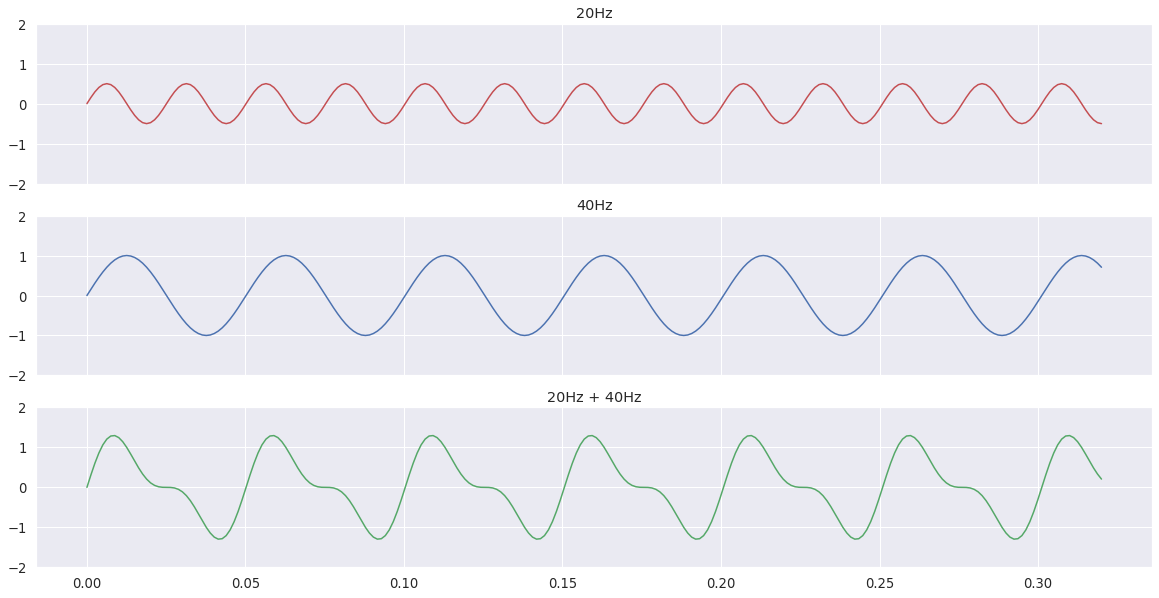

In [4]:
# Sample points
N = 256
# Sampling Rate
F = 800.0
# Sample Spacing
T = 1.0/F


x = np.linspace(0, N * T, N)
freq = 20  #Hz

n = np.arange(0,N,1)

y1 = np.sin(2 * np.pi * freq * (n/F) )
y2 = np.sin(2 * np.pi * freq * (n/F) - np.pi)
y3 = 0.5 * np.sin(2 * np.pi * 40 * (n/F) )
sample1 = [list(y1),list(y2)]
sample2 = [list(y1),list(y1)]

with open("sample1.json","w") as fp:
    json.dump(sample1, fp)

with open("sample2.json","w") as fp:
    json.dump(sample2, fp)

f,ax = plt.subplots(3,1,figsize=(20,10),sharex=True)
ax[0].plot(x, y3, color='r')
ax[0].set(ylim=[-2,2],title='20Hz')

ax[1].plot(x, y1, color='b')
ax[1].set(ylim=[-2,2],title='40Hz')

ycomb = y1 + y3

ax[2].plot(x, ycomb, color='g')
ax[2].set(ylim=[-2,2],title='20Hz + 40Hz')

Now we perform FFT on the signal.

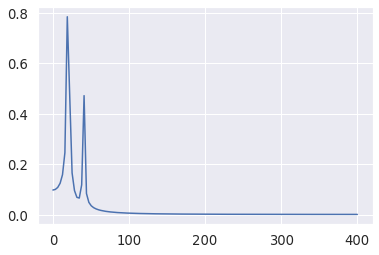

In [5]:
f_y1 = fft(ycomb)
xf= np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2/N * np.abs(f_y1[0:N//2]))


# Rolling Window Correlation Method

In [6]:
import pandas as pd
from scipy.signal import hilbert

def get_triangle(df,k=0):
    '''
    This function grabs the upper triangle of a correlation matrix
    by masking out the bottom triangle (tril) and returns the values.

    df: pandas correlation matrix
    '''
    x = np.hstack(df.mask(np.tril(np.ones(df.shape),k=k).astype(np.bool)).values.tolist())
    x = x[~np.isnan(x)]
    return x  

def rolling_correlation(data, wrap=False, *args, **kwargs):
    '''
    Intersubject rolling correlation.
    Data is dataframe with observations in rows, subjects in columns.
    Calculates pairwise rolling correlation at each time.
    Grabs the upper triangle, at each timepoints returns dataframe with
    observation in rows and pairs of subjects in columns.
    *args:
        window: window size of rolling corr in samples
        center: whether to center result (Default: False, so correlation values are listed on the right.)
    '''
    data_len = data.shape[0]
    half_data_len = int(data.shape[0]/2)
    start_len = data.iloc[half_data_len:].shape[0]
    if wrap:
        data = pd.concat([data.iloc[half_data_len:],data,data.iloc[:half_data_len]],axis=0).reset_index(drop=True)
    _rolling = data.rolling(*args, **kwargs).corr()       
    rs=[]
    for i in np.arange(0,data.shape[0]):
        rs.append(get_triangle(_rolling.loc[i]))
    rs = pd.DataFrame(rs)
    rs = rs.iloc[start_len:start_len+data_len].reset_index(drop=True)
    return rs  



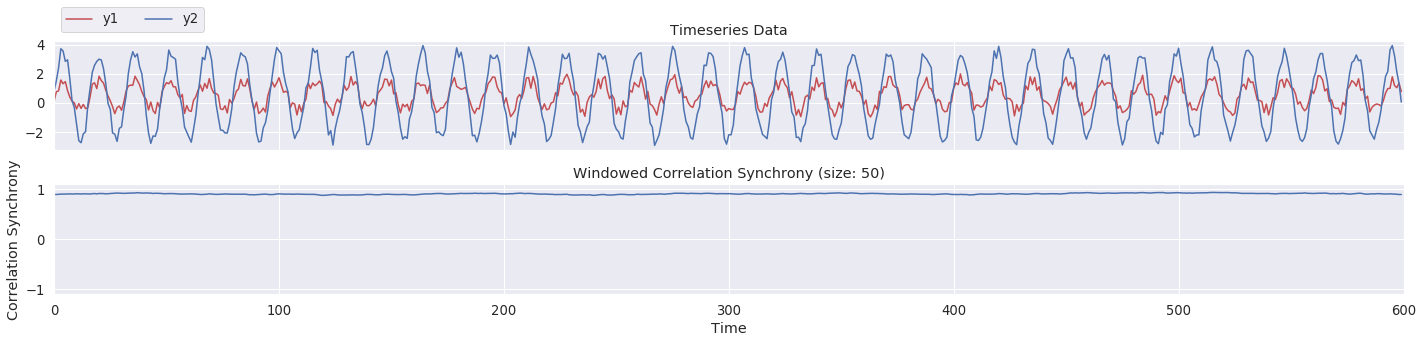

In [7]:
N = 600 # number of smaples
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
window_size = 50
phase_y1, phase_y2 = 50., 50.
amp_y1, amp_y2 = 1.,3.
y1 = amp_y1*np.sin(phase_y1 * 2.0*np.pi*x)+np.random.rand(N)
y2 = amp_y2*np.sin(phase_y2 * 2.0*np.pi*x)+np.random.rand(N)
window=10
al1 = None
al2 = None
f,ax = plt.subplots(2,1,figsize=(20,5),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Timeseries Data')
window_corr_synchrony = rolling_correlation(data=pd.DataFrame({'y1':y1,'y2':y2}),wrap=True,window=window_size,center=True)
window_corr_synchrony.plot(ax=ax[1],legend=False)
ax[1].set(ylim=[-1.1,1.1],xlim=[0,N],title='Windowed Correlation Synchrony (size: '+str(window_size)+')',xlabel='Time',ylabel='Correlation Synchrony')
plt.tight_layout()
plt.show()

# Synchrony using the Hilbert Transform Method

## First with clean in-phase signals

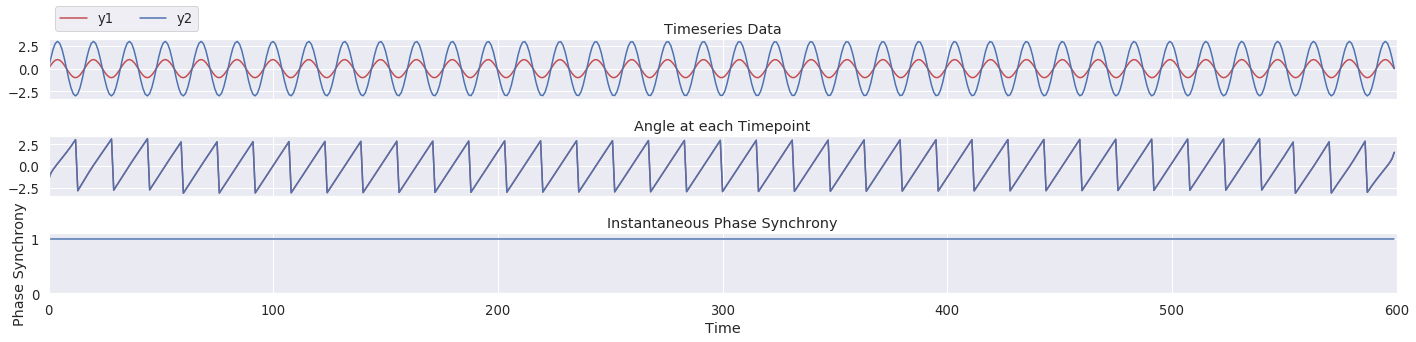

In [9]:
N = 600 # number of smaples
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
phase_y1, phase_y2 = 50., 50.
amp_y1, amp_y2 = 1.,3.
y1 = amp_y1*np.sin(phase_y1 * 2.0*np.pi*x)
y2 = amp_y2*np.sin(phase_y2 * 2.0*np.pi*x)
window=10
al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
f,ax = plt.subplots(3,1,figsize=(20,5),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Timeseries Data')
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(title='Angle at each Timepoint')
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()

## Now with noisy in-phase signals

[(0, 600), Text(0.5, 1.0, 'Synchrony')]

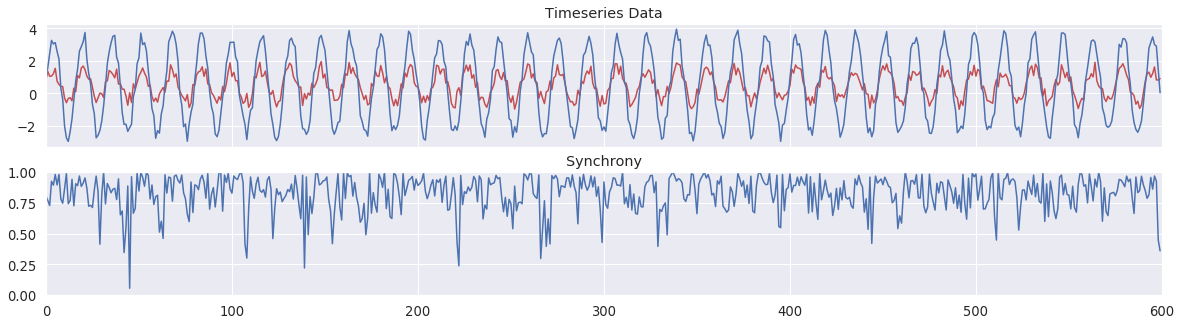

In [10]:
N = 600 # number of smaples
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
y1 = amp_y1*np.sin(phase_y1 * 2.0*np.pi*x)+np.random.rand(N)
y2 = amp_y2*np.sin(phase_y2 * 2.0*np.pi*x)+np.random.rand(N)
f_y1 = fft(y1)
f_y2 = fft(y2)

al1 = np.angle(hilbert(y1), deg=False)
al2 = np.angle(hilbert(y2), deg=False)
phase_synchrony = 1 - np.sin(np.abs(al1 - al2)/2)

f,ax = plt.subplots(2,1,figsize=(20,5),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].set(xlim=[0,N], title='Timeseries Data')

ax[1].plot(phase_synchrony)
ax[1].set(ylim=[0,1])
ax[1].set(xlim=[0,N], title='Synchrony')


## Noisy 180 out-of-phase signals

[(0, 600), Text(0.5, 1.0, 'Synchrony')]

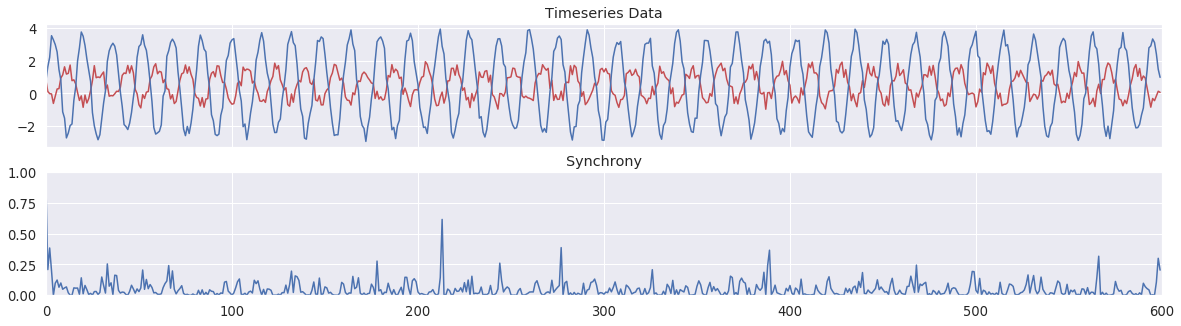

In [12]:
N = 600 # number of smaples
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
y1 = amp_y1*np.sin(phase_y1 * 2.0*np.pi*x-np.pi)+np.random.rand(N)
y2 = amp_y2*np.sin(phase_y2 * 2.0*np.pi*x)+np.random.rand(N)
f_y1 = fft(y1)
f_y2 = fft(y2)

al1 = np.angle(hilbert(y1), deg=False)
al2 = np.angle(hilbert(y2), deg=False)
phase_synchrony = 1 - np.sin(np.abs(al1 - al2)/2)

f,ax = plt.subplots(2,1,figsize=(20,5),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].set(xlim=[0,N], title='Timeseries Data')

ax[1].plot(phase_synchrony)
ax[1].set(ylim=[0,1])
ax[1].set(xlim=[0,N], title='Synchrony')

## Noisy 90 degree out of phase signals

[(0, 600), Text(0.5, 1.0, 'Synchrony')]

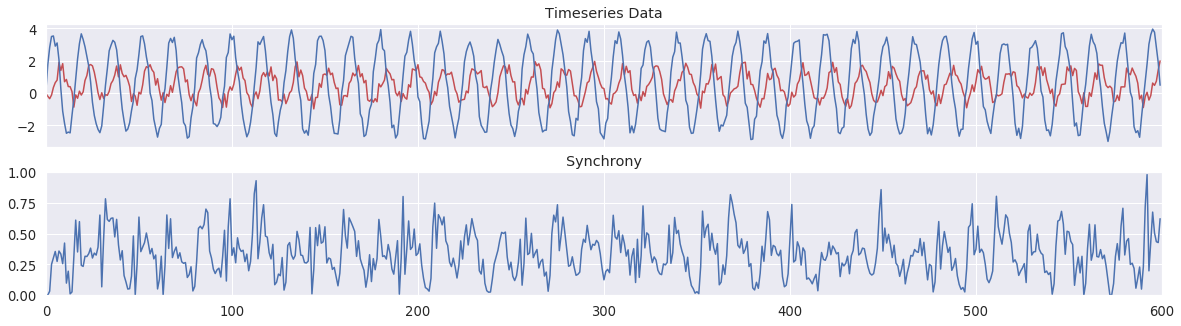

In [14]:
N = 600 # number of smaples
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
y1 = amp_y1*np.sin(phase_y1 * 2.0*np.pi*x - np.pi/2)+np.random.rand(N)
y2 = amp_y2*np.sin(phase_y2 * 2.0*np.pi*x)+np.random.rand(N)
f_y1 = fft(y1)
f_y2 = fft(y2)

al1 = np.angle(hilbert(y1), deg=False)
al2 = np.angle(hilbert(y2), deg=False)
phase_synchrony = 1 - np.sin(np.abs(al1 - al2)/2)

f,ax = plt.subplots(2,1,figsize=(20,5),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].set(xlim=[0,N], title='Timeseries Data')

ax[1].plot(phase_synchrony)
ax[1].set(ylim=[0,1])
ax[1].set(xlim=[0,N], title='Synchrony')

# Synchrony using Fourier Transform method (from the Thatcher Paper)

In [16]:
def synchrony_fft(y1,y2):
    f_y1 = np.fft.rfft(y1)[1:]
    f_y2 = np.fft.rfft(y2)[1:]

    a = f_y1.real
    b = -f_y1.imag
    u = f_y2.real
    v = -f_y2.imag

    cospectrum = a * u + b * v
    quadspectrum = a * v - b * u

    phase_difference = np.arctan2(quadspectrum,cospectrum)
    synchrony = 1 - np.abs(phase_difference) / np.pi
    return synchrony



## Clean in-phase signals

We get a synchrony value between 0 and 1 for each frequency bin

[(0, 600), Text(0.5, 1.0, 'Timeseries data')]

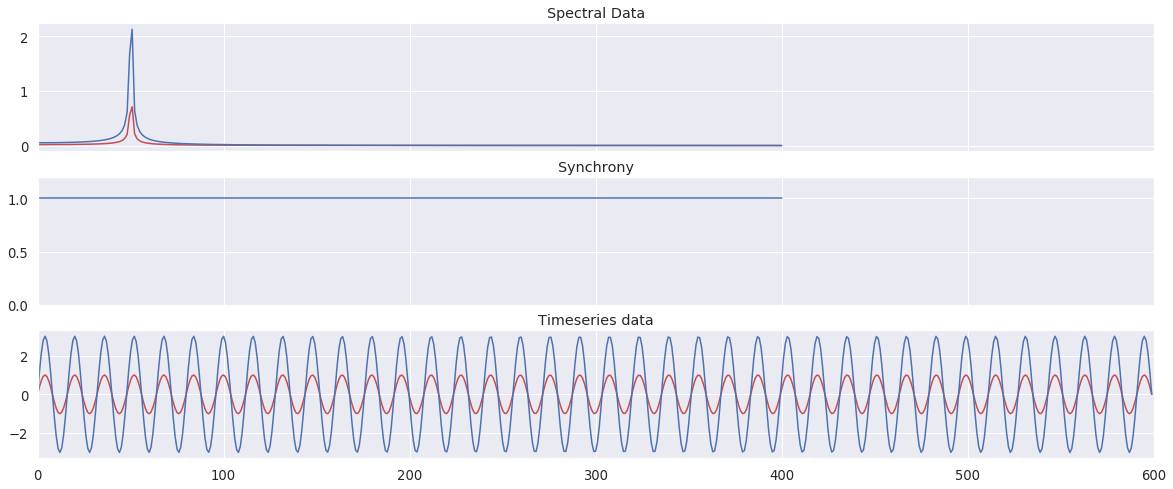

In [18]:
N = 600 # number of smaples
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
y1 = amp_y1*np.sin(50 * 2.0*np.pi*x)
y2 = amp_y2*np.sin(50 * 2.0*np.pi*x)
xf= np.linspace(0.0, 1.0/(2.0*T), N//2)

f_y1 = fft(y1)
f_y2 = fft(y2)

f,ax = plt.subplots(3,1,figsize=(20,8),sharex=True)
ax[0].plot(xf,2/N * np.abs(f_y1[0:N//2]),color='r',label='y1')
ax[0].plot(xf,2/N * np.abs(f_y2[0:N//2]),color='b',label='y2')
ax[0].set(xlim=[0,N//2], title='Spectral Data')

synchrony = synchrony_fft(y1,y2)

ax[1].plot(xf, synchrony)
ax[1].set(ylim=[0,1.2])

ax[2].plot(y1,color='r',label='y1')
ax[2].plot(y2,color='b',label='y2')
ax[2].set(xlim=[0,N])

ax[1].set(xlim=[0,N//2], title='Synchrony')
ax[2].set(xlim=[0,N], title='Timeseries data')


## 180deg out-of-phase signals

[(0, 600), Text(0.5, 1.0, 'Timeseries data')]

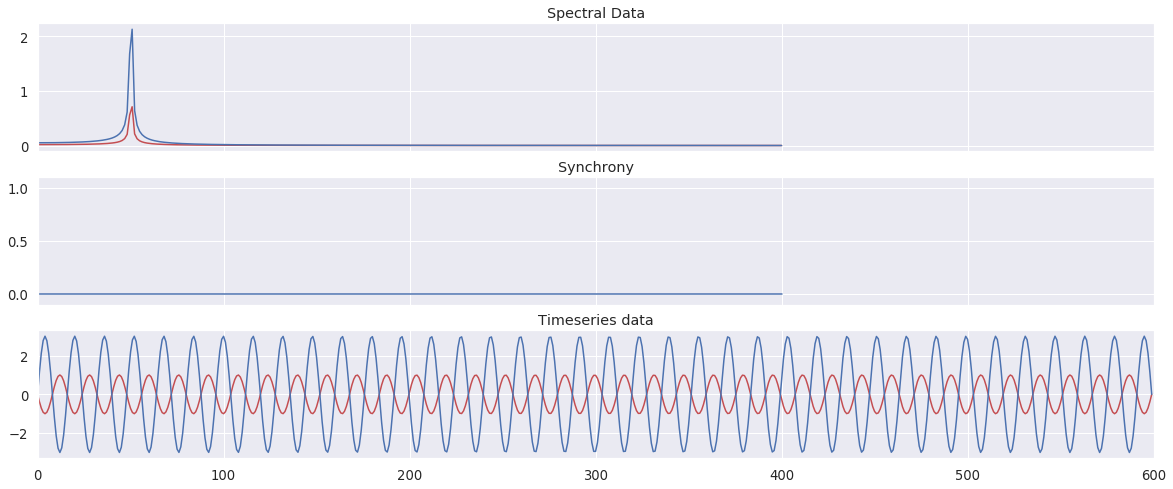

In [19]:
N = 600 # number of smaples
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
y1 = amp_y1*np.sin(50 * 2.0*np.pi*x - np.pi)
y2 = amp_y2*np.sin(50 * 2.0*np.pi*x)
xf= np.linspace(0.0, 1.0/(2.0*T), N//2)

f_y1 = fft(y1)
f_y2 = fft(y2)

f,ax = plt.subplots(3,1,figsize=(20,8),sharex=True)
ax[0].plot(xf,2/N * np.abs(f_y1[0:N//2]),color='r',label='y1')
ax[0].plot(xf,2/N * np.abs(f_y2[0:N//2]),color='b',label='y2')
ax[0].set(xlim=[0,N//2], title='Spectral Data')

synchrony = synchrony_fft(y1,y2)

ax[1].plot(xf, synchrony)
ax[1].set(ylim=[-0.1,1.1])

ax[2].plot(y1,color='r',label='y1')
ax[2].plot(y2,color='b',label='y2')
ax[2].set(xlim=[0,N])

ax[1].set(xlim=[0,N//2], title='Synchrony')
ax[2].set(xlim=[0,N], title='Timeseries data')


## 90 deg out of phase signals

[(0, 600), Text(0.5, 1.0, 'Timeseries data')]

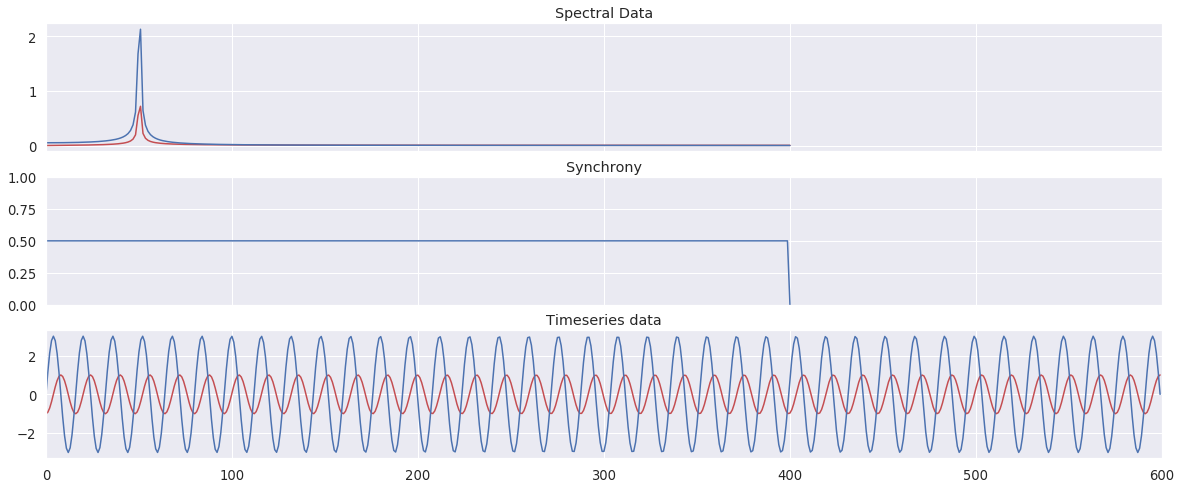

In [20]:
N = 600 # number of smaples
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
y1 = amp_y1*np.sin(50 * 2.0*np.pi*x - np.pi/2)
y2 = amp_y2*np.sin(50 * 2.0*np.pi*x)
xf= np.linspace(0.0, 1.0/(2.0*T), N//2)

f_y1 = fft(y1)
f_y2 = fft(y2)

f,ax = plt.subplots(3,1,figsize=(20,8),sharex=True)

ax[0].plot(xf,2/N * np.abs(f_y1[0:N//2]),color='r',label='y1')
ax[0].plot(xf,2/N * np.abs(f_y2[0:N//2]),color='b',label='y2')
ax[0].set(xlim=[0,N//2], title='Spectral Data')

synchrony = synchrony_fft(y1,y2)
ax[1].plot(xf, synchrony)
ax[1].set(ylim=[0,1])

ax[2].plot(y1,color='r',label='y1')
ax[2].plot(y2,color='b',label='y2')
ax[2].set(xlim=[0,N])

ax[1].set(xlim=[0,N//2], title='Synchrony')
ax[2].set(xlim=[0,N], title='Timeseries data')

## Now using the data karina sent me

[(0, 256), Text(0.5, 1.0, 'Timeseries data')]

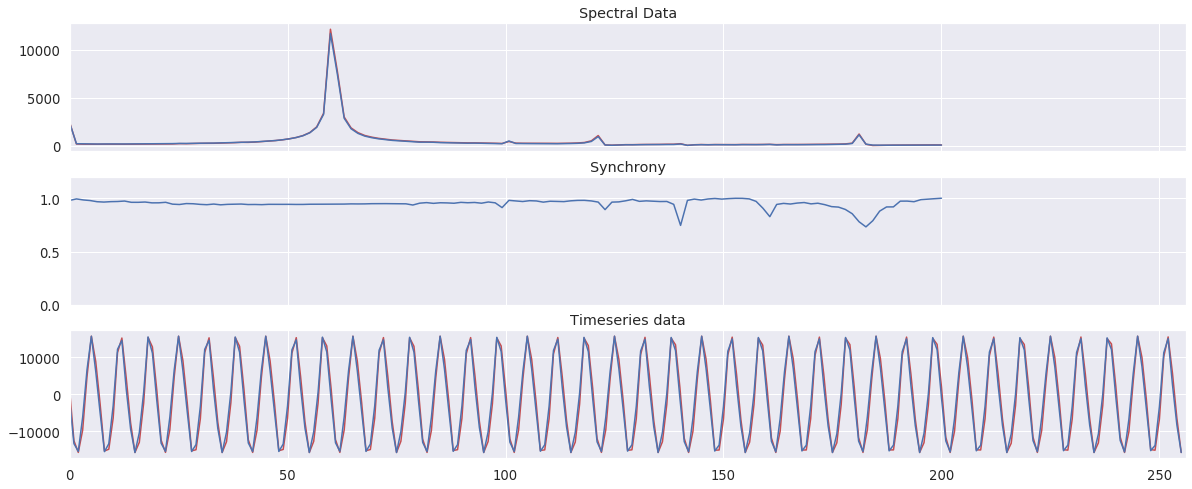

In [21]:
with open("samples-data.json") as fp:    
    a = json.load(fp)
sample = np.asarray(a)
y1 = sample[0]
y2 = sample[1]
x = np.linspace(0.0, N*T, N)
sampleRate = 400
N = len(sample[0])
T = 1/sampleRate

xf= np.linspace(0.0, 1.0/(2.0*T), N//2)

f_y1 = fft(y1)
f_y2 = fft(y2)

f,ax = plt.subplots(3,1,figsize=(20,8),sharex=True)

ax[0].plot(xf, 2/N * np.abs(f_y1[0:N//2]), color='r', label='y1')
ax[0].plot(xf, 2/N * np.abs(f_y2[0:N//2]), color='b', label='y2')
ax[0].set(xlim=[0,N//2], title='Spectral Data')

synchrony = synchrony_fft(y1, y2)
ax[1].plot(xf, synchrony)
ax[1].set(ylim=[0,1.2])

ax[2].plot(y1, color='r', label='y1')
ax[2].plot(y2, color='b', label='y2')
ax[2].set(xlim=[0,N])

ax[1].set(xlim=[0,N//2], title='Synchrony')
ax[2].set(xlim=[0,N], title='Timeseries data')

## One datapoint out of phase

[(0, 255), Text(0.5, 1.0, 'Timeseries data')]

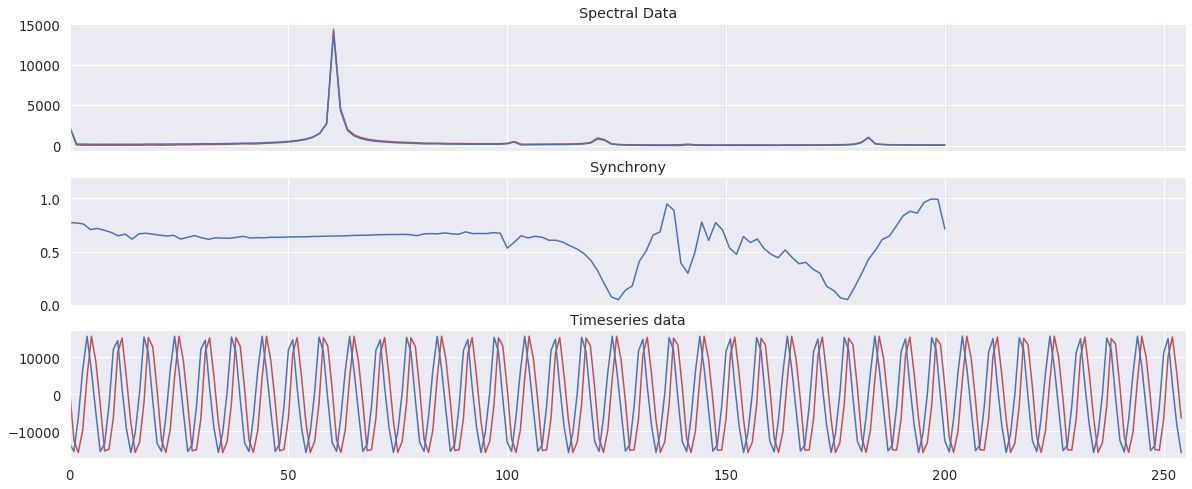

In [23]:
with open("samples-data.json") as fp:    
    a = json.load(fp)
sample = np.asarray(a)
y1 = sample[0]
y2 = sample[1]

n = 1
y1 = y1[:-n]
y2 = y2[n:]

sampleRate = 400
N = len(y1)
T = 1/sampleRate
x = np.linspace(0.0, N*T, N)
xf= np.linspace(0.0, 1.0/(2.0*T), N//2)

f_y1 = fft(y1)
f_y2 = fft(y2)

f,ax = plt.subplots(3,1,figsize=(20,8),sharex=True)

ax[0].plot(xf, 2/N * np.abs(f_y1[0:N//2]), color='r', label='y1')
ax[0].plot(xf, 2/N * np.abs(f_y2[0:N//2]), color='b', label='y2')
ax[0].set(xlim=[0,N//2], title='Spectral Data')

synchrony = synchrony_fft(y1, y2)
ax[1].plot(xf, synchrony)
ax[1].set(ylim=[0,1.2])

ax[2].plot(y1, color='r', label='y1')
ax[2].plot(y2, color='b', label='y2')
ax[2].set(xlim=[0,N])

ax[1].set(xlim=[0,N//2], title='Synchrony')
ax[2].set(xlim=[0,N], title='Timeseries data')

## Some experiments with synthetic noisy data

In [25]:
def apply_noise(s, noise=0):
    return s * (1 + (np.random.rand(len(s))-0.5) * noise)
    

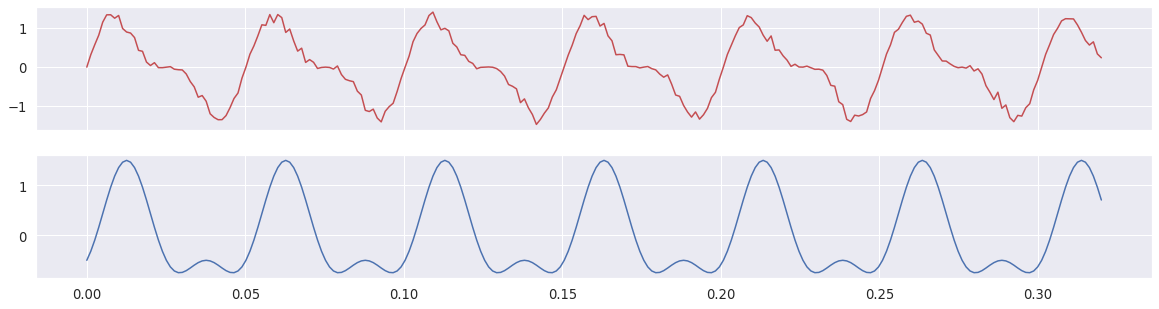

In [26]:
# Sample points
N = 256
# Sampling Rate
F = 800.0
# Sample Spacing
T = 1.0/F

noise = 0

x = np.linspace(0, N * T, N)

freq1 = 20  #Hz
freq2 = 40  #Hz

n = np.arange(0,N,1)

y1a = np.sin(2 * np.pi * freq1 * (n/F) )
y1a = apply_noise(y1a, 0.4)
y1b = 0.5 * np.sin(2 * np.pi * freq2 * (n/F) )

y2a = np.sin(2 * np.pi * freq1 * (n/F) ) 
y2b = 0.5 * np.sin(2 * np.pi * freq2 * (n/F) - np.pi/2 )

y1 = y1a + y1b
y2 = y2a + y2b

f,ax = plt.subplots(2,1,figsize=(20,5),sharex=True)
ax[0].plot(x, y1, color="r")
ax[1].plot(x, y2, color="b")


[(0, 128), Text(0.5, 1.0, 'Synchrony')]

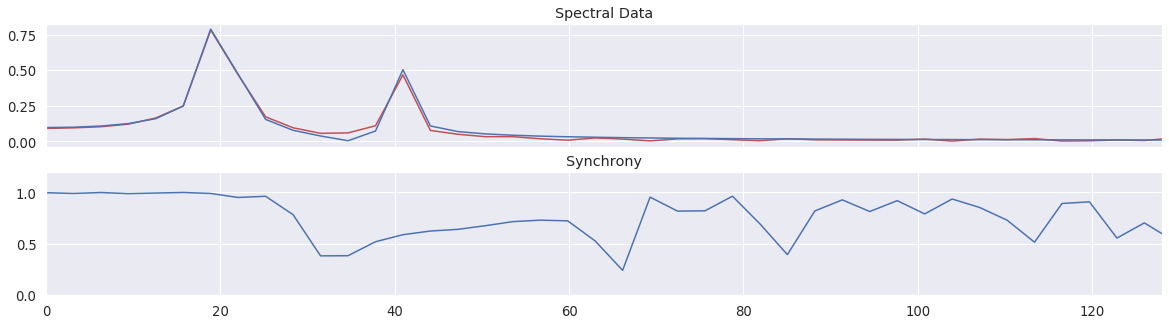

In [27]:
xf= np.linspace(0.0, 1.0/(2.0*T), N//2)

f_y1 = fft(y1)
f_y2 = fft(y2)

f,ax = plt.subplots(2,1,figsize=(20,5),sharex=True)

ax[0].plot(xf,2/N * np.abs(f_y1[0:N//2]),color='r',label='y1')
ax[0].plot(xf,2/N * np.abs(f_y2[0:N//2]),color='b',label='y2')
ax[0].set(xlim=[0,N//2], title='Spectral Data')

synchrony = synchrony_fft(y1,y2)
ax[1].plot(xf, synchrony)
ax[1].set(ylim=[0,1.2])

ax[1].set(xlim=[0,N//2], title='Synchrony')